In [1]:
import logging

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import norm

from Preprocessing import Preprocessing
from FeatureEngineering import FeatureEngineering
from Calendar import RussianBusinessCalendar

In [2]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")

df = pd.read_excel('data/Project 2_2023.xlsx', sheet_name='Data', parse_dates=['Date'], date_parser=date_parser)
df = df.set_index('Date')
df.index.name = 'Date'
df['Balance_correct'] = df['Income'] - df['Outcome']

In [3]:
prep = Preprocessing()
series = prep.preprocess(df['Balance_correct'])

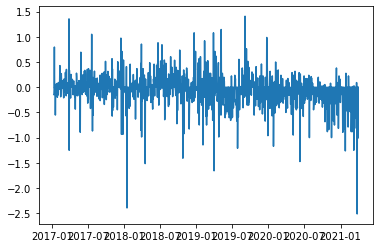

In [4]:
plt.plot(series)

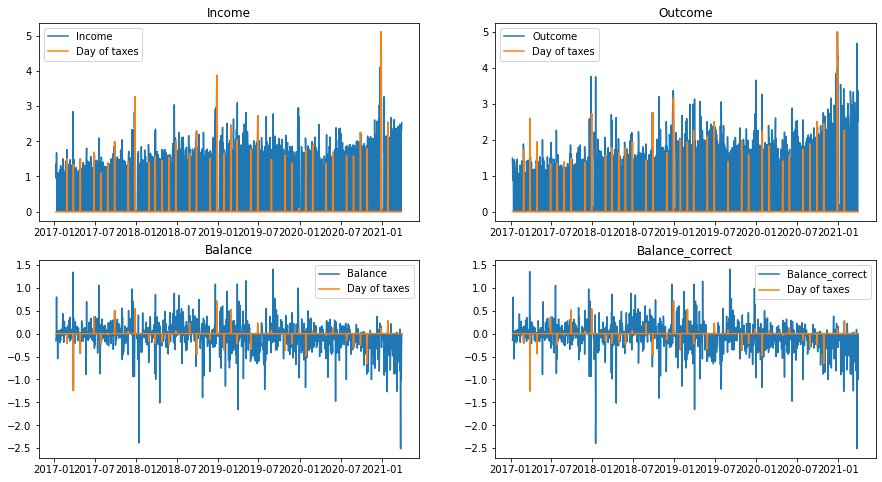

In [5]:
df['Taxes'] = list(pd.Series(df.index).apply(lambda x: 1 if x.day == 28 else 0))

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for i, column in enumerate(df.columns[:4]):
    axs[i//2][i%2].plot(df[column], label=column)
    axs[i//2][i%2].plot(df[column]*df['Taxes'], label='Day of taxes')
    axs[i//2][i%2].set_title(column)
    axs[i//2][i%2].legend()

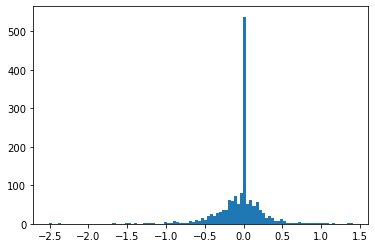

In [6]:
plt.hist(df['Balance_correct'], bins=100)
print()

# Поиск аномалий

# FE

In [7]:
series

2017-01-09   -0.144836
2017-01-10   -0.125572
2017-01-11    0.007767
2017-01-12    0.796823
2017-01-13   -0.019721
                ...   
2021-03-27    0.000000
2021-03-28    0.000000
2021-03-29   -1.013855
2021-03-30   -0.250172
2021-03-31    0.000000
Length: 1543, dtype: float64

In [8]:
# fe = FeatureEngineering(series)
# a = fe.get_features()

Feature Extraction: 100%|███████████████████████| 20/20 [00:06<00:00,  3.30it/s]


  0%|          | 0/658 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/elina/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/elina/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    self = reduction.pickle.load(from_parent)
  File "/Users/elina/opt/anaconda3/lib/python3.9/site-packages/tsfresh/__init__.py", line 27, in <module>
  File "/Users/elina/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    from tsfresh.convenience.relevant_extraction import (  # noqa: E402
  File "/Users/elina/opt/anaconda3/lib/python3.9/site-packages/tsfresh/convenience/relevant_extraction.py", line 5, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/Users/elina/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickl

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/elina/opt/anaconda3/lib/python3.9/site.py", line 589, in <module>
    main()
  File "/Users/elina/opt/anaconda3/lib/python3.9/site.py", line 576, in main
Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
    known_paths = addsitepackages(known_paths)
  File "/Users/elina/opt/anaconda3/lib/python3.9/site.py", line 359, in addsitepackages
  File "/Users/elina/opt/anaconda3/lib/python3.9/site.py", line 589, in <module>
  File "/Users/elina/opt/anaconda3/lib/python3.9/multiprocessing/__init__.py", line 16, in <module>
    addsitedir(sitedir, known_paths)
  File "/Users/eli

Traceback (most recent call last):
  File "/Users/elina/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gp/d5yy5f9519l8zrr4c7cd8yc80000gn/T/ipykernel_10904/3963261642.py", line 2, in <module>
    a = fe.get_features()
  File "/Users/elina/Documents/GitHub/TimeSeries-Project/FeatureEngineering.py", line 115, in get_features
    self.auto_fe()
  File "/Users/elina/Documents/GitHub/TimeSeries-Project/FeatureEngineering.py", line 105, in auto_fe
    extracted_features_filtered = select_features(extracted_features, series_tmp)
  File "/Users/elina/opt/anaconda3/lib/python3.9/site-packages/tsfresh/feature_selection/selection.py", line 165, in select_features
    relevance_table = calculate_relevance_table(
  File "/Users/elina/opt/anaconda3/lib/python3.9/site-packages/tsfresh/feature_selection/relevance.py", line 208, in calculate_relevance_table
    map_function(
  

TypeError: object of type 'NoneType' has no len()

In [17]:
features = pd.read_csv('FE.csv', sep=';', index_col=0)
target = series.shift(-1)[:-1]

# FS

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso


class FeatureSelection():
    def __init__(self, features, target, k_features=50):
        self.features = features
        self.target = target
        self.k_features = k_features
        self.wrapper_features = None
        self.correlation_features = None
        self.filter_features = None
        
    # Оберточный метод
    def wrapper_method(self):
        feature_selector = SequentialFeatureSelector(Lasso(),
           k_features=self.k_features,
           forward=True,
           verbose=2,
           scoring='neg_mean_absolute_error',
           cv=4)
        features = feature_selector.fit(np.array(self.features.fillna(0)), self.target)
        self.wrapper_features = self.features[self.features.columns[list(features.k_feature_idx_)]]
        return self.wrapper_features
    
    # Фильтр – корреляция
    def correlation_method(self):
        corr = dict()
        for i in self.features.columns:
            corr[i] = [self.target.corr(self.features[i])]
        self.correlation_features = \
                self.features[pd.DataFrame(corr).T.sort_values(0, 
                                                               key=abs, 
                                                               ascending=False).iloc[:self.k_features].index]
        return self.correlation_features

    # Фильтр
    def filtered_method(self):
        # Remove quasi-constant features
        filter_ = VarianceThreshold(threshold=0.01)
        constant_filter.fit(self.features)
        self.filter_features = constant_filter.transform(self.features)
        return filter_features
        



In [27]:
from pyitlib import discrete_random_variable as drv
a = drv.information_mutual_conditional(features[chosen_columns].values.flatten().reshape(2, -1), 
                                   pd.DataFrame(target.values), 
                                   features[[features.columns[2]]])

ValueError: dimensions of args X, Y, Z do not match

In [28]:
features[chosen_columns]#.values.flatten().reshape(-1, 2)

,holidays
2017-01-09,False
2017-01-10,False
2017-01-11,False
2017-01-12,False
2017-01-13,False
...,...
2021-03-26,False
2021-03-27,False
2021-03-28,False
2021-03-29,False


In [ ]:
features[chosen_columns].values.flatten()

In [ ]:
1

In [ ]:
mutual_info_regression(features[chosen_columns], target)

In [20]:
chosen_columns = [features.columns[1]]
for column in features.columns[1:]:
    print(column, )

holidays
weekdays
taxes_day
month
quarter
year
weekofyear
day_of_year
daysinmonth
is_leap_year
is_month_end
is_month_start
is_quarter_end
is_quarter_start
is_year_end
is_year_start
diffs_1
diffs_2
diffs_3
diffs_4
diffs_5
diffs_6
diffs_7
diffs_8
diffs_9
diffs_10
diffs_11
diffs_12
diffs_13
diffs_14
lag_1
lag_2
lag_3
lag_4
lag_5
lag_6
lag_7
lag_8
lag_9
lag_10
lag_11
lag_12
lag_13
lag_14
median_2
std_2
max_2
min_2
median_3
mean_3
std_3
max_3
min_3
median_4
mean_4
std_4
max_4
min_4
median_5
mean_5
std_5
max_5
min_5
median_6
mean_6
std_6
max_6
min_6
median_7
mean_7
std_7
max_7
min_7
median_8
mean_8
std_8
max_8
min_8
median_9
mean_9
std_9
max_9
min_9
median_10
mean_10
std_10
max_10
min_10
median_11
mean_11
std_11
max_11
min_11
median_12
mean_12
std_12
max_12
min_12
median_13
mean_13
std_13
max_13
min_13
median_14
mean_14
std_14
max_14
min_14
fourier_sin_1
fourier_cos_1
fourier_sin_2
fourier_cos_2
fourier_sin_3
fourier_cos_3
fourier_sin_4
fourier_cos_4
fourier_sin_5
fourier_cos_5
fourier_sin_6

In [ ]:
x = 

In [ ]:
len(x)

In [ ]:
features = a
target = series.shift(-1)[:-1]

In [ ]:
fs = FeatureSelection(features, target)
res = fs.wrapper_method()
res_cor = fs.correlation_method()
res_filter = fs.filtered_method()

# Model select

In [ ]:
res_cor

# Калибровка

# Поиск разладки

In [ ]:
class Stat(object):
    def __init__(self, threshold, direction="unknown", init_stat=0.0):
        self._direction = str(direction)
        self._threshold = float(threshold)
        self._stat = float(init_stat)
        self._alarm = self._stat / self._threshold
    
    @property
    def direction(self):
        return self._direction

    @property
    def stat(self):
        return self._stat
        
    @property
    def alarm(self):
        return self._alarm
        
    @property
    def threshold(self):
        return self._threshold
    
    def update(self, **kwargs):
        # Statistics may use any of the following kwargs:
        #   ts - timestamp for the value
        #   value - original value
        #   mean - current estimated mean
        #   std - current estimated std
        #   adjusted_value - usually (value - mean) / std
        # Statistics call this after updating '_stat'
        self._alarm = self._stat / self._threshold
        
def normal_likelihood(value, mean_0, mean_8, std):
    return np.log(norm.pdf(value, mean_0, std) / norm.pdf(value, mean_8, std))

class Cusum(Stat):
    def __init__(self, mean_0, mean_8, std,
                 threshold, direction="unknown", init_stat=0.0):
        self.mean_0 = mean_0
        self.mean_8 = mean_8
        self.std = std
        super(Cusum, self).__init__(threshold, direction, init_stat)
        
    def update(self, value):
        zeta_k = normal_likelihood(value, self.mean_0, self.mean_8,
                                  self.std)
        self._stat = max(0, self._stat + zeta_k)
        super(Cusum, self).update()
        
stat_trajectory = []
mean_0 = 2.
mean_8 = 0.
std = 1.

cusum = Cusum(mean_0, mean_8, std, 100.)
for x_k in df['Balance_correct']:
    cusum.update(x_k)
    stat_trajectory.append(cusum._alarm)
    
plt.plot(stat_trajectory)        

# Model

# Predict